In [1]:
import tensorflow as tf
from copy import  deepcopy
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import random
import datetime

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [3]:
from model_deep import Model

In [4]:
def mnist_imshow(img):
    plt.imshow(img.reshape([28, 28]), cmap='gray')
    plt.axis('off')

# return a new mnist dataset w/ pixels randomly permuted
def permute_mnist(mnist):
    perm_inds = list(range(mnist.train.images.shape[1]))
#     print (range(mnist.train.images.shape[1]))
    np.random.shuffle(perm_inds)
    mnist2 = deepcopy(mnist)
    sets = ["train", "validation", "test"]
    for set_name in sets:
        this_set = getattr(mnist2, set_name) # shallow copy
#         print (np.array([this_set.images[:,i] for i in [1,2,3,4]]).shape)
        #dafaq is with ._images, where did this shit come from, but okay moving on with lyf 
        this_set._images = np.transpose(np.array([this_set.images[:,c] for c in perm_inds]))
    return mnist2

In [5]:
# return a new mnist dataset filtered by selected digits
def filter_mnist(mnist, digits=[]):
    mnist2 = deepcopy(mnist)
    sets = ["train", "validation", "test"]
    for set_name in sets:
        this_set = getattr(mnist2, set_name) # shallow copy
        this_set._images = np.array([this_set.images[i] for i in range(this_set.images.shape[0]) 
                                     if np.argmax(this_set.labels[i]) in digits])
        this_set._labels = np.array([this_set.labels[i] for i in range(this_set.labels.shape[0]) 
                                     if np.argmax(this_set.labels[i]) in digits])
        this_set._num_examples = this_set.labels.shape[0]
    return mnist2

In [6]:
def train_model(model, train_set, test_sets, num_iters, test_freq):
    test_accs = np.zeros((len(test_sets), num_iters // test_freq))
    
    for idx in range(num_iters):
        if idx % test_freq == 0:
            for t, test_set in enumerate(test_sets):
                feed_dict = {model.x: test_set.test.images, model.labels:test_set.test.labels}
                accuracy = model.accuracy.eval(feed_dict=feed_dict)
                test_accs[t, idx // test_freq] = accuracy

        train_batch = train_set.train.next_batch(10)
        feed_dict = {model.x: train_batch[0], model.labels: train_batch[1]}
        model.train_step.run(feed_dict=feed_dict)
        
        if idx % test_freq == 0:
            print(f'\rIteration {idx+1}/{num_iters}', end='')

    print(f'\rTraining  {num_iters}/{num_iters} done.')
    return test_accs

In [7]:
def calc_accs(param_list, data_sets, iters_per_dataset, test_freq, session):
    print(f"Calculation started at {datetime.datetime.now()}")
    k = iters_per_dataset // test_freq
    ds_num = len(data_sets)
    accs = np.zeros((len(param_list), len(data_sets), len(data_sets) * k))
    for m_idx, params in enumerate(param_list):
        model = Model(params[0])
        session.run(tf.global_variables_initializer())
        test_sets = []
        for d_idx, data_set in enumerate(data_sets):
            test_sets.append(data_set)
            model.open_lesson(params[1], params[2], params[3], params[4])
            cur_accs = train_model(model, data_set, test_sets, iters_per_dataset, test_freq)
            idxs = list(range(data_set.validation.images.shape[0]))
            random.shuffle(idxs)
            test_set = data_set.validation.images[idxs]
            model.close_lesson(test_set, session)
            for t_idx in range(ds_num):
                if t_idx < len(test_sets):
                    acc_arr = cur_accs[t_idx]
                else:
                    acc_arr = [None]*k
                for idx in range(k):
                    accs[m_idx][t_idx][k*d_idx+idx] = acc_arr[idx]
            accs[m_idx][t_idx][0] = 0.0
        del model
    return accs

In [8]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sess = tf.InteractiveSession()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [9]:
mnist1 = filter_mnist(mnist, [0,1,2,3,4])
mnist2 = filter_mnist(mnist, [5,6,7,8,9])
data_sets=[mnist1, mnist2]

In [10]:
# test structure
net = [784, 350, 150, 10]
params = [(net, Model.SGD, Model.SIGNAL, .3, 0.), 
          (net, Model.EWC, Model.SIGNAL, .3, 1.),
          (net, Model.EWC, Model.FISHER, .3, 15.),
          (net, Model.WVA, Model.SIGNAL, .3, 3000.),
          (net, Model.WVA, Model.FISHER, .3, 45000.)]

In [11]:
iters_per_task = 2800
test_freq = 1
idxs = np.array(range(1, iters_per_task*len(data_sets)+1, test_freq))

In [12]:
accs = []
for i in range(10):
    accs.append(calc_accs(params, data_sets, iters_per_task, test_freq, sess))
    print(f"Step {i} done.")

Calculation started at 2020-03-30 13:53:13.589233
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.
Instructions for updating:
Use tf.cast instead.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Step 0 done.
Calculation started at 2020-03-30 13:58:44.433548
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Step 1 done.
Calculation started at 2020-03-30 14:04:13.428518
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/2800 done.
Training  2800/280

In [13]:
accs_arr = np.array(accs)

In [14]:
np.save('pic3_data.npy', accs_arr)

In [13]:
accs_arr = np.load('pic3_data.npy')

In [15]:
accs = accs_arr.mean(axis=0)

In [ ]:
plt.figure(figsize = (6, 3.6))
plt.title('Training task B')
plt.xlabel('a) using SGD optimizer')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
plt.plot(idxs[2790:2990], accs[0,0][2790:2990], label='Task A')
plt.plot(idxs[2790:2990], accs[0,1][2790:2990], label='Task B')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (6, 3.6))
plt.title('Training task B')
plt.xlabel('Training time')
#plt.xlabel('b) using EWC-F optimizer')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
plt.plot(idxs[2790:2990], accs[1,0][2790:2990], label='Task A')
plt.plot(idxs[2790:2990], accs[1,1][2790:2990], label='Task B')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (6, 3.6))
plt.title('Training task B')
plt.xlabel('Training time')
#plt.xlabel('b) using EWC-F optimizer')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
plt.plot(idxs[2790:2990], accs[2,0][2790:2990], label='Task A')
plt.plot(idxs[2790:2990], accs[2,1][2790:2990], label='Task B')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (6, 3.6))
plt.title('Training task B')
plt.xlabel('Training time')
#plt.xlabel('b) using EWC-F optimizer')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
plt.plot(idxs[2790:2990], accs[3,0][2790:2990], label='Task A')
plt.plot(idxs[2790:2990], accs[3,1][2790:2990], label='Task B')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (6, 3.6))
plt.title('Training task B')
plt.xlabel('Training time')
#plt.xlabel('b) using EWC-F optimizer')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
plt.plot(idxs[2790:2990], accs[4,0][2790:2990], label='Task A')
plt.plot(idxs[2790:2990], accs[4,1][2790:2990], label='Task B')
plt.legend()
plt.show()

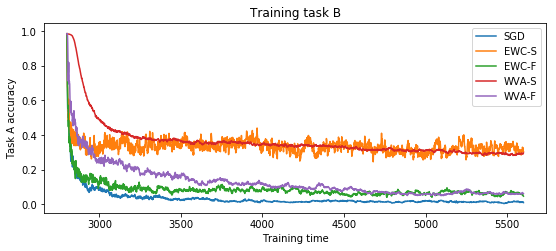

In [37]:
plt.figure(figsize = (9, 3.5))
plt.title('Training task B')
plt.xlabel('Training time')
plt.ylabel('Task A accuracy')
plt.ylim(-0.05, 1.05)
plt.plot(idxs[2800:], accs[0,0][2800:], label='SGD')
plt.plot(idxs[2800:], accs[1,0][2800:], label='EWC-S')
plt.plot(idxs[2800:], accs[2,0][2800:], label='EWC-F')
plt.plot(idxs[2800:], accs[3,0][2800:], label='WVA-S')
plt.plot(idxs[2800:], accs[4,0][2800:], label='WVA-F')
plt.legend()
plt.show()

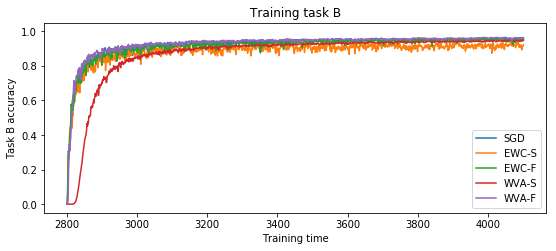

In [35]:
plt.figure(figsize = (9, 3.5))
plt.title('Training task B')
plt.xlabel('Training time')
plt.ylabel('Task B accuracy')
plt.ylim(-0.05, 1.05)
plt.plot(idxs[2800:4100], accs[0,1][2800:4100], label='SGD')
plt.plot(idxs[2800:4100], accs[1,1][2800:4100], label='EWC-S')
plt.plot(idxs[2800:4100], accs[2,1][2800:4100], label='EWC-F')
plt.plot(idxs[2800:4100], accs[3,1][2800:4100], label='WVA-S')
plt.plot(idxs[2800:4100], accs[4,1][2800:4100], label='WVA-F')
plt.legend()
plt.show()